# Here are many hyperparameters to play with !!!
- **Total loss function**
$$L(G, C, S) = \alpha * L_{content}(G, C) + \beta * L_{style}(G, S) + \gamma * L_{var}(G)$$
    - **Trade-off between content and style matching**
        - $\alpha$ and $\beta$ weight the relative importance of content loss and style loss, and when $\alpha / \beta$ is a crucial factor that control the apperance of generated image.
        - When $\alpha / \beta$ is large, meaning place strong emphasis on content, the generated image can be clearly identified, but the style of image is not as well-matched. (say $\alpha / \beta = 1 \times 10^{-1}$)
        - When place strong emphasis on style, we will get a highly texturised version of the style image. (say $\alpha / \beta = 1 \times 10^{-4}$)
        - Here, the recommended value of $\alpha / \beta is \frac{0.025}{5.0}$. But I find $\frac{0.025}{50.0}$ a nice one.
    - **function of $L_{var}$**  
    Total variation loss is used to measure the total difference of neighbor pixels (exactly step 1 takes nearest neighbor pixels both from horizontal and vertical orientation). **Could I use large step? Will it cause blur??**
- **Content loss function**
$$L_{content}(G, C) = \frac{1}{2} \mid\mid \phi^{[l]}(G) - \phi^{[l]}(C) \mid\mid _2^2 \qquad (Gatys \, version)$$
$$L_{content}(G, C) = \frac{1}{C_l H_l W_l} \mid\mid \phi^{[l]}(G) - \phi^{[l]}(C) \mid\mid _2^2 \qquad (Johnson \, version)$$
$$L_{content}(G, C) = \mid\mid \phi^{[l]}(G) - \phi^{[l]}(C) \mid\mid _2^2 \qquad (NARAYANAN \, version)$$
$$L_{content}(G, C) = \frac{1}{4 C_l H_l W_l} \mid\mid \phi^{[l]}(G) - \phi^{[l]}(C) \mid\mid _2^2 \qquad (deeplearning.ai \, version)$$
    - **Feature reconstruction layer**  
    Treat this as a feature reconstruction problem, our goal is to find an new image that perfectly match the original image on the feature map on a chosen layer. So we start to find a image by minimizing the Euclidean distance between two feature representations. And the result shows that using deeper layer, the generated image keeps the object and their arrangement in the original image well, but discards exact pixel value.  
    So if you want to retain content well in the generated image (say you want to stylize a picture of a man and don't want the edge of face and body to jigger too much), choose shallow layer for content loss computation.  
    Conv2_2 is recommended by NARAYANAN since he is stylize a picture of children's face.
    - **Coefficient in the formula**  
    When the total loss only consists of content loss, the coefficient of this formula is of no importance (except for simplifying the derivative formula). However, when the content loss combines with style loss, the coefficient somehow controls the relative weight of them. And since the relative weight between them is important as mentioned above, the best choice of $\alpha / \beta$ will change depending on your choice here.  
    And I find the first formula with $\frac{0.025}{50.0}$ a visual pleasing one.
- **Style loss function**
$$L_{style}(G, S) = $$
    - **Gram matrix**
    - **Style reconstruction layers**
    - **Size of Style Image**  
    The Gram matrix used to represent the style of feature representation is of shape $n_C \times n_C$, which is not affected by the input size, so any size of style image can be used. But what should be kept in mind is that, when you use the same several layers to compute style loss with same style image but in different size, the scale of texture these layer capture will be different. Because when layers are chosen, the neurons in them have the fixed receptive field. But with large style image, the texture scales they can capture are smaller than with small style image. It seems the reverse. But think about an style image with a bndbox of receptive field on it, with the bndbox fixed, you begin to scale the image to larger size, and you can find that the bndbox capture smaller textures.  
    **Gatys recommended using the style image of the same size as content image?????**
    - **Variation to Gram matrix**

# Neural Style Transfer

- **Contents of notebook**:
    - Problem Description
    - Why Convolutional Neural Network
    - Texture Sythesis
    - Why Gram Matrix
    - Neural Style Transfer
    - Real-Time style Transfer
    - Modification to Gram Matrix

## Problem Description

# Neural Style Transfer
#### Rather than optimize a cost function to get parameters, style transfer algorithm optimizes a cost function to get pixel values.
#### To generate image combining the style of style image and content of content image.
$$G^* = \mathop{\arg\min}_G \ \left( \alpha {\scr J}_{content}(C, G) + \beta {\scr J}_{style}(S, G) \right)$$  
### Convnets pre-trained for image classification have already learnt to encode perceptual and semantic information that we need to measure semantic difference terms of content and style

In [26]:
import os
import numpy as np
import tensorflow as tf
import scipy
import scipy.io
import scipy.misc
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

## Transfer Learning
#### use a neural network trained on a different task and apply it on a new task.
#### $VGG-19 \; trained \; on \; Imagenet \; \begin{cases} recognize \; low \; level \; feature \; at \; the \; earlier \; layers \\ 
recognize \; high \; level \; features \; at \; the \; deeper \; layers \end{cases}$

## Parameters & Hyperparameters

In [2]:
class CONFIG:
    IMAGE_HEIGHT = 512
    IMAGE_WIDTH = 512
    COLOR_CHANNELS = 3
    content_weight = 0.025
    style_weight = 5.0
    total_variation_weight = 0.1
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    CONTENT_LAYER = 'conv2_2'
    STYLE_LAYERS = [
    ('conv1_2', 0.2),
    ('conv2_2', 0.2),
    ('conv3_3', 0.2),
    ('conv4_3', 0.2),
    ('conv5_3', 0.2)]
    lr = 5.0
    iterations = 1000
    model_path = 'C:/Users/徐根利/Desktop/'
    content_input_file = 'C:/Users/徐根利/Desktop/content_input/gavin.jpg'
    style_input_file = 'C:/Users/徐根利/Desktop/style_input/Edtaonisl.jpg'
    save_path = 'C:/Users/徐根利/Desktop/output/'

**tips:**  
<font color='purple'>
    1. **How do you choose the coefficients (STYLE_LAYERS) for each layer?**  
    The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if you want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if you want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers.  
    2. **How do you choose the layer for measuring the content cost?**  
    The earlier (shallower) layers of a ConvNet tend to detect lower-level features such as edges and simple textures, and the later (deeper) layers tend to detect higher-level features such as more complex textures as well as object classes. In practice, you'll get the most visually pleasing results if you choose a layer in the middle of the network--neither too shallow nor too deep.  
    3. **How do you choose the $\alpha$ and $\beta$?**  
    $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style, remaining to be tested.
</font>

## Load parameters for the VGG model
**Attention!**  
OpenCV uses picture in the form of **BGR**, so the VGG model substracts the mean values (116.779, 103.939, 123.68) in BGR form, if the input is in **RBG** form, remember to use (123.68, 116.779, 103.939)!

In [3]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

## Loss function
#### $J(G) = \alpha J_{content}(C, G) + \beta J_{style}(S, G)$

- ### Content Cost
$$J_{content}(C, G) = \frac{1}{4 \times n_H \times n_W \times n_C} \sum_{all \, entries} \left( a^{(C)} - a^{(G)} \right)^2$$  
Higher layers in the network capture the high-level content in terms of objects and their arrangement in the input image but **do not constrain the exact pixel values** of the reconstruction. They try to keep more semantic information and are more invariant to small changes in color, edge and texture.

In [4]:
def compute_content_cost(a_C, a_G):
    """
    compute the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activation representing content of image C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activation representing content of image S
    
    Returns:
    J_content -- scalar, content cost
    """
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, [n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, [n_H * n_W, n_C])
    
    #J_content = 1/(4 * n_H * n_W * n_C) * tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))
    J_content = 1 / 2 * tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))
    
    return J_content

- ### Style Cost
$$J_{content}^{[l]}(S, G) = \frac{1}{4 \times n_H^2 \times (n_W \times n_C)^2} \sum_{i=0}^{n_C} \sum_{j=0}^{n_C} \left( G_{ij}^{(S)} - G_{ij}^{(G)} \right)^2$$

- #### Gram matrix
    - #### Gram matrix of a set of vectors $(v_1, \ldots, v_n)$
    $G_{ij} = v_i^T v_j = np.dot(v_i, v_j)$  
    $G_{ij} \; compares \; how \; similar \; v_j \; is \; to \; v_i, \; if \; they \; are \; highly \; similar, \; the \; G_{ij} \; should \; be \; large$    
    
    Gram matrix is proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content.(https://arxiv.org/abs/1606.01286)  
    
    Using true covariance matrix also works, but it is computationally expensive.

In [5]:
def gram_matrix(A):
    """
    Create gram matrix of A
    
    Arguments:
    A -- tensor of shape (n_C, n_H*n_W), feature map of one layer
    
    Returns:
    G -- tensor of shape (n_C, n_C), gram matrix of A
    """
    
    G = tf.matmul(A, tf.transpose(A))
    
    return G

In [6]:
def compute_layer_style_cost(a_S, a_G):
    """
    compute style cost in a particular layer
    
    Arguments:
    a_S -- tensor of shape (1, n_H, n_W, n_C), hidden layer activations representing style of style image
    a_G -- tensor of shape (1, n_H, n_W, n_C), hidden layer activations representing style of generated image
    
    Returns:
    layer_style_cost - scalar, style cost in one hidden layer
    """
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S_unrolled = tf.reshape(a_S, [n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, [n_H * n_W, n_C])
    
    GS = gram_matrix(tf.transpose(a_S_unrolled))
    GG = gram_matrix(tf.transpose(a_G_unrolled))
    
    J_style_layer = 1/(4 * (n_C)**2 * (n_H*n_W)**2) * tf.reduce_sum(tf.square(GS - GG))
    
    return J_style_layer

$$J_{style}(S, G) = \sum_l \lambda ^{[l]} J_{style}^{[l]}(S, G)$$

In [7]:
def compute_style_cost(model, STYLE_LAYERS = CONFIG.STYLE_LAYERS):
    """
    compute the style cost along several hidden layers
    
    Arguments:
    model -- a pretrained VGG model
    STYLE_LAYERS -- a python list containing:
                        - hidden layer names
                        - style weight of that hidden layer
    
    Returns:
    J_style -- style cost of all selected hidden layers
    """
    
    J_style = 0
    
    for layer_name, weight in STYLE_LAYERS:
        
        out = model[layer_name]
        
        a_S = sess.run(out)
        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        
        J_style += weight * J_style_layer
    
    return J_style

Use only the content cost and style cost to optimize, you will find the output is quite noisy. **So add a total variation cost (a regularisation term) to encourage spatial smoothness**
$$
a = \left( G(:, 1:, :n_W-1, :) - G(:, :n_H-1, :n_W-1, :) \right)^2
\\
b = \left( G(:, :n_H-1, 1:, :) - G(:, :n_H-1, :n_W-1, :) \right)^2
\\
J_{variation}(G) = \sum (a + b)^{1.25}$$

In [8]:
def compute_total_variation_cost(X):
    """
    compute the total variation cost as a regularisation term to encourage spatial smoothness
    
    Arguments:
    X -- tensor of shape (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS), generated image
    
    J_variation -- scalar, variation cost of generated image
    """
    
    a = tf.square(X[:, 1:, :-1, :] - X[:, :-1, :-1, :])
    b = tf.square(X[:, :-1, 1:, :] - X[:, :-1, :-1, :])
    
    J_variation = tf.reduce_sum(tf.pow(a + b, 1.25))
    
    return J_variation

$$J(G) = \alpha  J_{content}(C, G) + \beta J_{style}(S, G) + \gamma J_{variation}(G)$$

In [9]:
def compute_total_cost(J_content, J_style, J_variation, alpha = CONFIG.content_weight, beta = CONFIG.style_weight, gamma = CONFIG.total_variation_weight):
    """
    compute the total cost of generated image away from content image and style image
    
    Arguments:
    J_content -- content cost
    J_style -- style cost
    alpha -- hyperparameter weighting the importance of content cost
    beta -- hyperparameter weighting the importance of style cost
    
    Returns:
    J -- total cost
    """
    
    J = alpha * J_content + beta * J_style + gamma * J_variation
    
    return J

## Optimize the total cost J(G) with respect to G

In [10]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

In [11]:
def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image

In [12]:
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, content_image.shape).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image
    #input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

In [13]:
def save_image(image, path = CONFIG.save_path):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

d:\python\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
d:\python\python36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


size of content image is (1, 512, 512, 3)


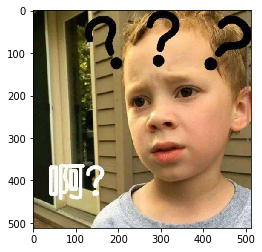

In [14]:
# load content image
content_image = scipy.misc.imread(CONFIG.content_input_file)
content_image = scipy.misc.imresize(content_image, (CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH))
plt.imshow(content_image)

content_image = reshape_and_normalize_image(content_image)
print('size of content image is', content_image.shape)

d:\python\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
d:\python\python36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


size of style image is (1, 512, 512, 3)


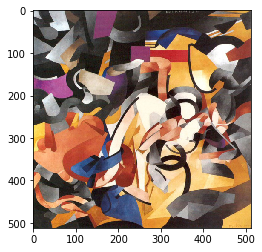

In [15]:
# load style image
style_image = scipy.misc.imread(CONFIG.style_input_file)
style_image = scipy.misc.imresize(style_image, (CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH))
plt.imshow(style_image)

style_image = reshape_and_normalize_image(style_image)
print('size of style image is', style_image.shape)

In [16]:
# generate noise image
generated_image = generate_noise_image(content_image)
print('size of generated image is ', generated_image.shape)

size of generated image is  (1, 512, 512, 3)


In [17]:
# load the VGG model
model = load_vgg_model(CONFIG.model_path + "imagenet-vgg-verydeep-19.mat")

In [18]:
# define the content cost
sess.run(tf.assign(model['input'], content_image))
out = model[CONFIG.CONTENT_LAYER]
a_C = sess.run(out)
a_G = out

J_content = compute_content_cost(a_C, a_G)

In [19]:
print('size of a_C is ' + str(a_C.shape))
print('size of a_G is ' + str(a_G.shape))

size of a_C is (1, 256, 256, 128)
size of a_G is (1, 256, 256, 128)


In [20]:
# define the style cost
sess.run(tf.assign(model['input'], style_image))

J_style = compute_style_cost(model, STYLE_LAYERS = CONFIG.STYLE_LAYERS)

In [21]:
# define the total variation cost
G_v = model['input']

J_variation = compute_total_variation_cost(G_v)

In [22]:
# define the total cost
J = compute_total_cost(J_content, J_style, J_variation)

In [23]:
# define optimizer and train_step
optimizer = tf.train.AdamOptimizer(CONFIG.lr)

train_step = optimizer.minimize(J)

#optimizer = tf.contrib.opt.ScipyOptimizerInterface(J, method='L-BFGS-B', options={'maxiter': CONFIG.iterations, 'disp': 0})

In [24]:
def model_nst(sess, input_image, name, iterations = CONFIG.iterations):
        
    init = tf.global_variables_initializer()
    sess.run(init)
    
    sess.run(tf.assign(model['input'], input_image))
    
    step = []
    total_loss = []
    content_loss = []
    style_loss = []
    variation_loss = []
    
    for i in range(iterations + 1):
        
        if i % 20 == 0:
            
            Jt, Jc, Js, Jv = sess.run([J, J_content, J_style, J_variation])
            print('On iteration %d : total cost is %e, content cost is %e, style cost is %e, variation cost is %e'%(i, Jt, Jc, Js, Jv))
            
            step.append(i)
            total_loss.append(Jt)
            content_loss.append(Jc)
            style_loss.append(Js)
            variation_loss.append(Jv)
            
            generated_image = sess.run(model['input'])
            save_image(generated_image, path = CONFIG.save_path + name + str(i) + '.png')
    
        sess.run(train_step)
    
    loss_info = (step, total_loss, content_loss, style_loss, variation_loss)
    
    return generated_image, loss_info

In [25]:
G, loss_info = model_nst(sess, generated_image, 'gavin')

On iteration 0 : total cost is 5.070359e+09, content cost is 1.475005e+11, style cost is 2.317984e+08, variation cost is 2.238541e+09


d:\python\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


On iteration 20 : total cost is 1.388934e+09, content cost is 3.895865e+10, style cost is 5.337377e+07, variation cost is 1.480989e+09
On iteration 40 : total cost is 6.371174e+08, content cost is 1.484327e+10, style cost is 3.139304e+07, variation cost is 1.090706e+09
On iteration 60 : total cost is 3.918188e+08, content cost is 6.448689e+09, style cost is 2.750193e+07, variation cost is 9.309194e+08


KeyboardInterrupt: 

In [ ]:
step, total_loss, content_loss, style_loss, variation_loss = loss_info
plt.plot(step, total_loss)
plt.plot(step, content_loss)
plt.plot(step, style_loss)
plt.plot(step, variation_loss)
plt.title('loss of objective functions')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(['total loss', 'content loss', 'style loss', 'variation loss'])

***

# Apply Neural Style Transfer in Real-Time

## Train A Feedforward Image Transformation Network